### 1. Import Libraries
#### This cell imports the necessary libraries for the entire workflow.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import pandas as pd 
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt 
from tensorflow.keras import layers, models
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

### 2. Define Paths to Dataset Directories
#### This cell defines the paths to the dataset directories for training, validation, and testing.

In [2]:
data_dir = Path("/kaggle/input/bone-fracture-dataset/BoneFractureDataset")
train_dir = data_dir / 'training'
test_dir = data_dir / 'testing'
val_dir = data_dir / 'testing'

### 3. Define Parameters
#### This cell defines parameters such as batch size and image dimensions.

In [3]:
BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180

In [4]:
import tensorflow as tf

### 4. Load the Datasets
#### This cell loads the datasets from the directories using `image_dataset_from_directory`.

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                              image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              batch_size=BATCH_SIZE)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              batch_size=BATCH_SIZE)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                              image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              batch_size=BATCH_SIZE)

Found 8863 files belonging to 2 classes.
Found 600 files belonging to 2 classes.
Found 600 files belonging to 2 classes.


In [6]:
class_names = train_ds.class_names
class_names

['fractured', 'not_fractured']

In [7]:
import matplotlib.pyplot as plt

In [8]:
class_names = train_ds.class_names

def show_images(dataset, title):
    plt.figure(figsize=(6, 6))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i+1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i]])
            plt.axis('off')
    plt.suptitle(title)
    plt.show()

### 5. Plot some images from both class

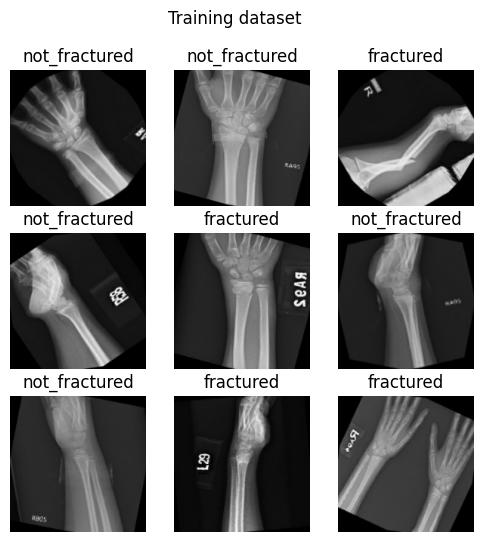

In [9]:
show_images(train_ds, 'Training dataset')

### 6. Plot class distributions

In [10]:
from pathlib import Path

In [11]:
def count_classes(dataset, class_name):
    return len(list(Path.glob(dataset, f"{class_name}/*")))

def create_class_counts_df(dataset, class_names):
    counts = {'class':[], 'count': []}
    for class_name in class_names:
        counts['class'].append(class_name)
        counts['count'].append(count_classes(dataset, class_name))
    return pd.DataFrame(counts)

def plot_class_distribution(df, title, palette="viridis"):
    sns.barplot(x='class', y='count', data=df, palette=palette)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

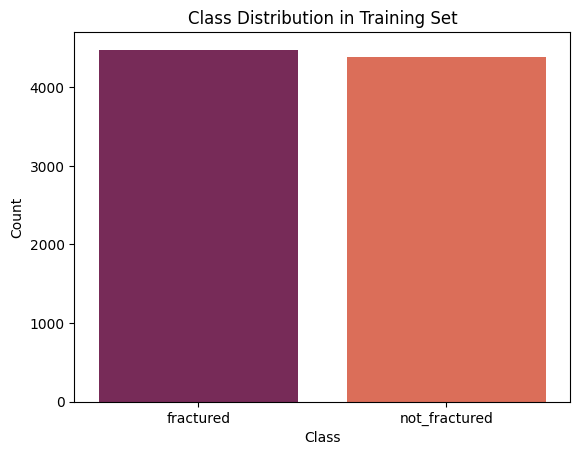

In [12]:
train_df = create_class_counts_df(train_dir, class_names)
plot_class_distribution(train_df, 'Class Distribution in Training Set', palette='rocket')

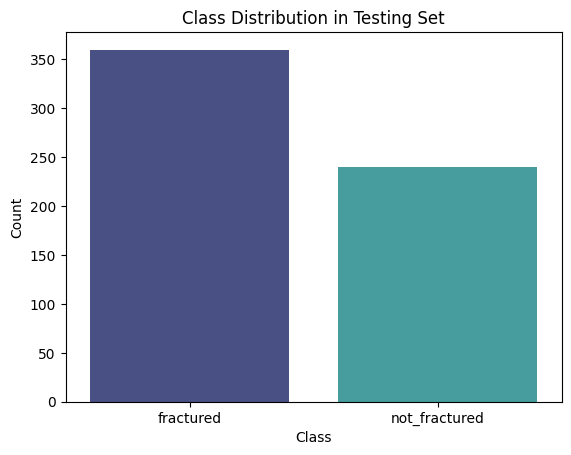

In [13]:
test_df = create_class_counts_df(test_dir, class_names)
plot_class_distribution(test_df, 'Class Distribution in Testing Set', palette='mako')

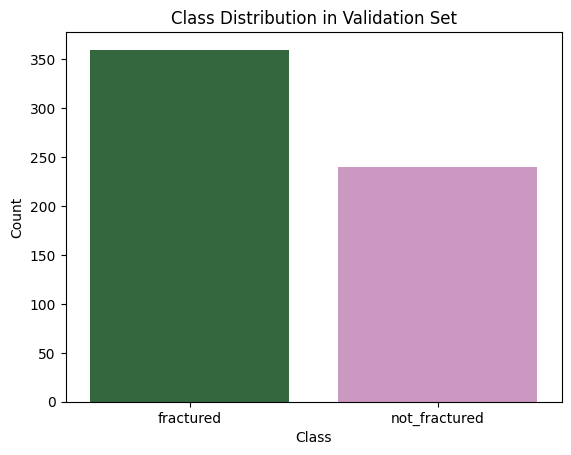

In [14]:
val_df = create_class_counts_df(val_dir, class_names)
plot_class_distribution(val_df, 'Class Distribution in Validation Set', palette='cubehelix')

### 7. Set Up Data Generators
#### This cell use `ImageDataGenerator` for loading and augmenting the training, validation, and test datasets.

In [15]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
training_set = train_datagen.flow_from_directory(train_dir,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                batch_size=32,
                                                class_mode='binary')

Found 8863 images belonging to 2 classes.


In [17]:
test_set = train_datagen.flow_from_directory(test_dir,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                batch_size=32,
                                                class_mode='binary')

Found 600 images belonging to 2 classes.


In [18]:
val_set = train_datagen.flow_from_directory(val_dir,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                batch_size=32,
                                                class_mode='binary')

Found 600 images belonging to 2 classes.


### 8. Define the Model
#### This cell defines the `Convolutional Neural Network (CNN)` model architecture.

In [19]:
model = models.Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,105 (25.36 MB)

 Trainable params: 6,647,105 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### 9. Compile the Model
#### This cell compiles the model, specifying the optimizer, loss function, and metrics.

In [20]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### 10. Train the Model
#### This cell trains the model using the training dataset and validates it using the validation dataset, saving the training history.

In [21]:
history = model.fit(training_set,
                   validation_data=test_set,
                   epochs=10
                   )

Epoch 1/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.5773 - loss: 0.6786 - val_accuracy: 0.5150 - val_loss: 0.6924
Epoch 2/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.7255 - loss: 0.5291 - val_accuracy: 0.7317 - val_loss: 0.5333
Epoch 3/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - accuracy: 0.8071 - loss: 0.3943 - val_accuracy: 0.7267 - val_loss: 0.5217
Epoch 4/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 308s 1s/step - accuracy: 0.8900 - loss: 0.2633 - val_accuracy: 0.7133 - val_loss: 0.5330
Epoch 5/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - accuracy: 0.9220 - loss: 0.1901 - val_accuracy: 0.6533 - val_loss: 0.6477
Epoch 6/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - accuracy: 0.9489 - loss: 0.1363 - val_accuracy: 0.6533 - val_loss: 0.7737
Epoch 7/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 309s 1s/step - accuracy: 0.9573 - loss: 0.1219 - val_accuracy: 0.6767 - val_loss: 0.8906
Epoch 8/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 306s 1s/step - accuracy: 0.9625 - loss: 0.1051 - val_accu

### 12. Evaluate the Model on the Test Dataset
#### This cell evaluates the trained model on the test dataset and prints the accuracy and loss.

In [22]:
test_loss, test_acc = model.evaluate(test_set)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 495ms/step - accuracy: 0.6877 - loss: 0.9161
Test Accuracy: 0.69
Test Loss: 0.91


### 13. Plot Training and Validation Accuracy and Loss
#### This cell plots the training and validation accuracy and loss over the epochs.

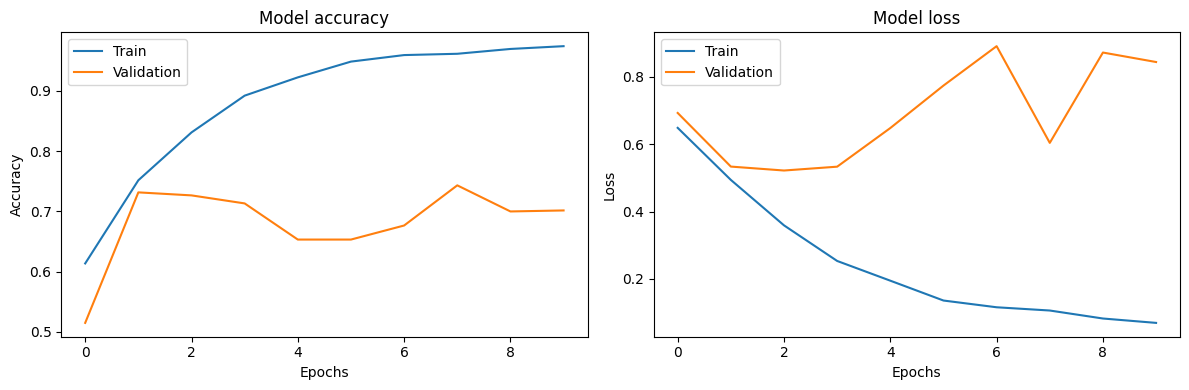

In [23]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

### 14. Save the Model
#### This cell saves the trained model to an .h5 file

In [24]:
model.save('fracture_classification_model.h5')

### 15. Load the Model
#### This cell loads the saved model from the .h5 file.

In [25]:
loaded_model = tf.keras.models.load_model('fracture_classification_model.h5')

### 16. Load and Preprocess Custom Image
#### This cell defines a function to load and preprocess a custom image.

In [26]:
def load_preprocessed_image(image_path, img_height=180, img_width=180):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((img_height, img_width))
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

image_path = '/kaggle/input/bone-fracture-dataset/BoneFractureDataset/testing/fractured/1-rotated1-rotated1-rotated3.jpg'
preprocessed_img = load_preprocessed_image(image_path)

### 17. Make Predictions on Custom Image

In [27]:
predictions = loaded_model.predict(preprocessed_img)
predicted_class = np.argmax(predictions, axis=1)  # Assuming categorical output
class_names = ['fractured', 'not fractured']
# For binary classification, use:
predicted_class = (predictions > 0.5).astype("int32")

# Print the predicted class
print(f"Predicted class: {class_names[predicted_class[0][0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Predicted class: fractured


#### This notebook covers the entire procedure for developing a deep learning model to classify images as `fractured` or `not fractured`. It covers `data loading`,` preprocessing`, `augmentation`, `model training`, `evaluation`, and result visualization, as well as saving the trained model and predicting custom images. This end-to-end procedure ensures an organized approach to creating and deploying an image classification model.